# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

#### Human Messagge:
This represents a message from the end-user. It's the input that drives the conversation forward.

- When to use: Use this for any prompt, question, or statement made by the human interacting with the AI. 
It's the most common message type you'll create.

#### AIMessage:
This represents a message from the AI model. It's the model's response in the conversation.

- When to use: Use this for the model's direct replies to the user. It's also essential when creating "few-shot" examples to show the model how it should behave in a conversation.

#### SystemMessage:
This provides initial instructions, context, or constraints to the AI model. It sets the rules for the conversation but isn't part of the back-and-forth dialogue itself.

- When to use: Use this at the beginning of a conversation to define the AI's persona, role, or task. It steers the model's behavior throughout the interaction.

#### ToolMessage:
This message holds the result or output from a tool call. Modern AI models can decide to use external tools (like a search engine or calculator), and this message is how you feed the result of that action back to the model.

- When to use: This is used in a two-step process for agentic behavior:

The AIMessage contains a tool_calls attribute, indicating the model wants to use a tool.

You execute that tool in your code and then pass its output back to the model inside a ToolMessage so it can formulate a final answer.


Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [21]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chatmodel:
Language models that use a sequence of messages as inputs and return chat messages as outputs (as opposed to using plain text). These are traditionally newer models (older models are generally LLMs). Chat models support the assignment of distinct roles to conversation messages, helping to distinguish messages from the AI, users, and instructions such as system messages.

In [22]:
import os 
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

LLM = ChatGroq(model= "deepseek-r1-distill-llama-70b")

In [23]:
result = LLM.invoke(messages)

In [24]:
result

AIMessage(content="<think>\nAlright, the user mentioned they want to learn about the best place to see orcas in the US. I remember they were initially asking about ocean mammals, so this is a follow-up. \n\nI should consider where orcas are commonly found. The Pacific Northwest comes to mind, especially places like Washington State. Orcas are iconic there. \n\nPuget Sound is a hotspot, so mentioning San Juan Islands, Seattle, and Friday Harbor makes sense. I should include tips like visiting in summer for better sightings.\n\nAlaska is another great spot. Seward and Juneau are popular for whale watching tours. It's good to highlight the summer months there too.\n\nMonterey Bay in California is known for its marine life. Including that could be helpful for users on the West Coast. Plus, mentioning the migratory season adds value.\n\nHawaii isn't as known for orcas, but they can be spotted there. It’s a good alternative, especially for those interested in warmer locations.\n\nIncluding t

In [25]:
result.response_metadata

{'token_usage': {'completion_tokens': 719,
  'prompt_tokens': 49,
  'total_tokens': 768,
  'completion_time': 3.009343245,
  'prompt_time': 0.017816621,
  'queue_time': 0.051203739,
  'total_time': 3.027159866},
 'model_name': 'deepseek-r1-distill-llama-70b',
 'system_fingerprint': 'fp_1bbe7845ec',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.


[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [26]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


In [27]:
llm_with_tools = LLM.bind_tools([multiply])

In [28]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is 2 multiplied by 3." I need to figure out the best way to assist them using the tools I have.\n\nLooking at the tools provided, there\'s a function called "multiply" which takes two integers, a and b, and returns their product. That seems perfect for this query.\n\nSo, I should call the multiply function with a=2 and b=3. I\'ll structure the tool call with the function name and the arguments in JSON format as specified.\n\nI need to make sure the arguments are correctly formatted as integers. Once I make the call, it should return 6, which is the product of 2 and 3.\n\nI should present the tool call in the required XML tags, ensuring the JSON inside is properly formatted.\n', 'tool_calls': [{'id': 'xq0tasy83', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 193, 'prompt_tokens': 153, 'total_tokens

In [29]:
tool_call.tool_calls


[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'xq0tasy83',
  'type': 'tool_call'}]

In [30]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'xq0tasy83',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [31]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
    messages:list[AnyMessage]
    

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [32]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [33]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='0e98cac5-b958-4301-9bf4-9a04c621c773'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='1b24a77c-2298-4fea-92e4-82311714bd84'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='7874e5a1-9c00-4cca-af2e-c955ce1a194c')]

## Graph

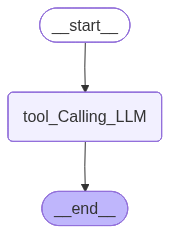

In [37]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

def tool_Calling_LLM(state: MessageState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessageState)
builder.add_node("tool_Calling_LLM", tool_Calling_LLM)
builder.add_edge(START, "tool_Calling_LLM")
builder.add_edge("tool_Calling_LLM", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
messages

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='40b85212-58cd-47d9-a048-c7aadb7f8f09')]}

In [39]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today? If you have any questions or need help with something, feel free to ask!


In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (7yadcpsb2)
 Call ID: 7yadcpsb2
  Args:
    a: 2
    b: 3


: 